In [1]:
from pathlib import Path
from moviepy.editor import VideoFileClip, AudioFileClip
from transformers import Wav2Vec2Tokenizer, Wav2Vec2ForCTC
import librosa
import matplotlib.pyplot as plt
from librosa import display
import numpy as np
import torch

In [2]:
video_file_path = Path("../Data/test_video.mp4")
audio_file_path = video_file_path.with_suffix(".wav")
pretrained_model_path = "../pretrained_model"

In [3]:
audio_tokenizer = Wav2Vec2Tokenizer.from_pretrained(pretrained_model_path)
audio_model = Wav2Vec2ForCTC.from_pretrained(pretrained_model_path)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at ../pretrained_model and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
video_clip = VideoFileClip(str(video_file_path))
# video_clip.audio.to_audiofile(str(audio_file_path))

In [4]:
audio_data, sampling_rate = librosa.load(str(audio_file_path), sr=None)

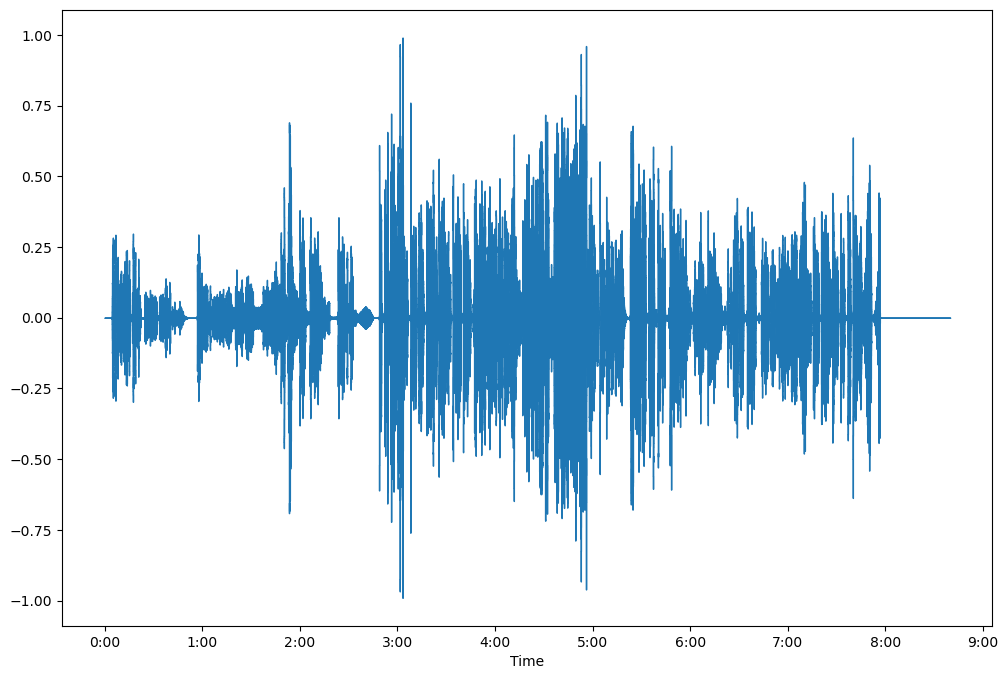

In [5]:
plt.figure(figsize=(12, 8))
display.waveshow(audio_data)
plt.show()

In [7]:
n_fft = 512
s = librosa.stft(audio_data, n_fft=n_fft, hop_length=n_fft//2)
D = librosa.amplitude_to_db(np.abs(s), ref=np.max)
np.max(abs(D))

80.0

In [7]:
non_mute_sections_timelines = librosa.effects.split(audio_data, 60)

In [8]:
len(audio_data)

11461589

In [9]:
non_mute_sections = []
for section_timelines in non_mute_sections_timelines:
    start_index, end_index = section_timelines
    non_mute_sections.append(audio_data[start_index: end_index])

In [13]:
# assert len(non_mute_sections) == len(non_mute_sections)
[len(x) for x in non_mute_sections]
# tmp_input = non_mute_sections[1]

[402944,
 1024,
 259584,
 103424,
 29184,
 136192,
 6144,
 13824,
 4096,
 5120,
 1798656,
 10240,
 19968,
 14848,
 17920,
 506368,
 3373568,
 2048,
 3402752]

In [11]:
tokenized_input = audio_tokenizer(tmp_input, return_tensors="pt").input_values

In [12]:
tokenized_input

tensor([[ 0.3139,  0.3951,  0.4763,  ...,  0.1277, -0.0394, -0.1587]])

In [14]:
# tmp_input = tokenized_input.unsqueeze(dim=0)
logits = audio_model(tokenized_input)

In [15]:
logits_idx = torch.argmax(logits.logits, dim=-1)
transcription = audio_tokenizer.batch_decode(logits_idx)

In [16]:
transcription

['']

In [ ]:
video_clip = VideoFileClip("../Data/test_video.mp4")
clip_end = video_clip.duration
clip_paths = []
for i in range(1, int(clip_end), 10):
    sub_end = min(i+10, clip_end)
    sub_clip = video_clip.subclip(i,sub_end)

    sub_clip.audio.write_audiofile("../Data/audio_" + str(i) + ".mp3")
    clip_paths.append("../Data/audio_" + str(i) + ".mp3")

In [30]:
caption = ""

for path in clip_paths:
    input_audio, _ = librosa.load(path, sr=16000)
    tokenized_input = audio_tokenizer(input_audio, return_tensors="pt").input_values

    with torch.no_grad():
        logits_idx = audio_model(tokenized_input).logits
        predicted_ids = torch.argmax(logits_idx, dim=-1)

    transcription = audio_tokenizer.batch_decode(predicted_ids)[0]
    caption += transcription + " "
    

In [31]:
caption

"SOURCE OF BELIEF WHEN THE ENGINEERING PROBLEM IS SO DIFFICULT THERE'S A LOT OF EXPERTS MANY OF WHOM YOU ADMIRE WHO HAVE FAILED IN THE PAST YES WHERE DO YOU GO TO BOTH PERSONALLY AM INTELLECTUALLY AS ENGENEER AS A TEAM LIKE FOUR SOURCE OF STRENGTH NEEDED TO SOT A PERSEVERE H THIS AND TO AD KEEP GONG WITH THE PROJECT TAKE T TO COMPLETION A SOURCE OF STRENGTH I DOESN'T REALLY KNOW HOW I THINK ABOUT THINGS IM I'M AIN FOR ME AT SIMPLY THIS THIS IS SOMETHING THAT IS IMPORTANT TO GET DONE UM AND WE WISH JUST KEEP DOING IT UM OR DIE TRYING AND I I ON'T NEED A SOURCE OF STRENGTH SO QUITTING IS NOT EVEN MYK GUM YET'S NOT IT'S ON OF MY NATURE OOKUM AND I I DON'T CARABOT OUGH MISMAL PASSIMISM IF UCK THAT WE'RE GOING TO GET IT DONE GOING TO GET IT DONE "